In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy.spatial import distance_matrix
from scipy import interpolate
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import emcee
from scipy.stats import uniform
from emcee.moves import WalkMove,DEMove
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

In [2]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("Updateddata.txt",names = columns)
datatab

x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']


# First dataset 
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
X1_train, X1_test, D1_train, D1_test, E1_train, E1_test = train_test_split(X1,dm1.reshape(-1, 1),em1,train_size=0.8,random_state=1)

# Second dataset
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test, E2_train, E2_test = train_test_split(X2, dm2.reshape(-1,1),em2, train_size=0.8, random_state=3)

# Third dataset
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test,E3_train, E3_test = train_test_split(X3, dm3.reshape(-1,1),em3, train_size=0.8, random_state=5)

# Fourth dataset
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test,E4_train, E4_test = train_test_split(X4, dm4.reshape(-1,1),em4, train_size=0.8, random_state=7)


X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
#E_train = np.concatenate((E1_train.reshape(-1,1),E2_train.reshape(-1,1),E3_train.reshape(-1,1),E4_train.reshape(-1,1)))
E_train = np.concatenate((E1_train,E2_train,E3_train,E4_train))
E_test = np.concatenate((E1_test,E2_test,E3_test,E4_test))

In [3]:
bounds_lmult = ((1e-2, 10), (1e-2, 10.0), (1e-2, 10.0), (1e-2, 10.0))  # Fix l1 bounds
guess_lmult = (1,1,1,1)
bounds_lsingle = (1e-4, 10.0)
ExpSinelbounds = (1e-1, 10.0)  
guess_lsingle = 1.0
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)
nu = 1.75
alpha = 1
periodicity = np.linspace(0.1, 3, 10)[7]
periodictybounds = (1, 10)
gamma = 1
noiselvlinit = 1
noiselvlboundsinit = (1e-20, 1e20)
noiselvlwerror = E.mean()
noiselvlboundswerror = noisebounds=(E.mean() - 2*1e-1, E.mean() + 2*1e-1)

noiselvl = [noiselvlinit, noiselvlwerror]
noiselvlbounds = [noiselvlboundsinit, noiselvlboundswerror]

fits =[]
stds = []
rmse = []
mae = []
r2 = []
adjustedr2 = []
fom = []

for noiselvl, noiselvlbounds in zip(noiselvl, noiselvlbounds):
    noiselvl = noiselvl
    noiselvlbounds = noiselvlbounds

    Matkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=guess_lmult, length_scale_bounds=bounds_lmult, nu=nu) + WhiteKernel(noise_level=noiselvl, noise_level_bounds=noiselvlbounds)
    Radkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RationalQuadratic(length_scale=guess_lsingle, alpha=alpha, length_scale_bounds=bounds_lsingle) + WhiteKernel(noise_level=noiselvl, noise_level_bounds=noiselvlbounds)
    ExpSinekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * ExpSineSquared(length_scale=guess_lsingle, periodicity=periodicity, length_scale_bounds=ExpSinelbounds,periodicity_bounds=periodictybounds)+ WhiteKernel(noise_level=noiselvl, noise_level_bounds=noiselvlbounds)
    Laplacekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * PairwiseKernel(gamma=gamma, metric='laplacian')+ WhiteKernel(noise_level=noiselvl, noise_level_bounds=noiselvlbounds)
    RBFkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=guess_lmult, length_scale_bounds=bounds_lmult)+ WhiteKernel(noise_level=noiselvl, noise_level_bounds=noiselvlbounds)
    kernel_list = [Radkernel, ExpSinekernel, Laplacekernel, RBFkernel,Matkernel]
    kernel_names = ['Rational Quadratic', 'ExpSineSquared', 'Laplacian', 'RBF','Matern']
    dimensionnames = [['sigma','alpha','l','noiselvl'],['sigma','l','periodicity','noiselvl'],['sigma','gamma','noiselvl'],['sigma','l1','l2','l3','l4','noiselvl'],['sigma','l1','l2','l3','l4','noiselvl']]
    
    for kernel, kernel_name, dimensionname in zip(kernel_list, kernel_names, dimensionnames):
        gpr = GaussianProcessRegressor(kernel=kernel,normalize_y=True, n_restarts_optimizer=2,random_state=42)
        gpr.fit(X_train, D_train)
        print(f"Fitted Kernel: {gpr.kernel_}")
        Dfit, Dstd = gpr.predict(X1, return_std=True)
        Dtestfit,Dteststd = gpr.predict(X1_test, return_std=True)
        pointwiseparams = np.exp(gpr.kernel_.theta)
        fits.append(Dfit)
        stds.append(Dstd) 
        rmse.append(np.sqrt(mean_squared_error(D1_test, Dtestfit)))
        mae.append(mean_absolute_error(D1_test, Dtestfit))
        r2.append(r2_score(D1_test, Dtestfit))
        adjustedr2.append(1 - (1-r2[-1])*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1))
        fom.append(np.mean(np.abs(D1_test - Dtestfit)/Dteststd))

Fitted Kernel: 1.31**2 * RationalQuadratic(alpha=1.76, length_scale=0.804) + WhiteKernel(noise_level=0.127)
Fitted Kernel: 1.32e-07**2 * ExpSineSquared(length_scale=0.205, periodicity=1.14) + WhiteKernel(noise_level=1)
Fitted Kernel: 2.8**2 * PairwiseKernel(gamma=0.34189602762133253, metric=laplacian) + WhiteKernel(noise_level=3.27e-10)
Fitted Kernel: 0.868**2 * RBF(length_scale=[0.111, 0.11, 1.06, 1.79]) + WhiteKernel(noise_level=0.00798)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Fitted Kernel: 1.01**2 * Matern(length_scale=[0.237, 0.205, 1.21, 3.35], nu=1.75) + WhiteKernel(noise_level=0.00744)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.44275510997454354. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Kernel: 1.25**2 * RationalQuadratic(alpha=5.88, length_scale=0.961) + WhiteKernel(noise_level=0.443)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.44275510997454354. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Kernel: 1.22**2 * ExpSineSquared(length_scale=0.596, periodicity=9.88) + WhiteKernel(noise_level=0.443)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.44275510997454354. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Kernel: 0.936**2 * PairwiseKernel(gamma=0.30439433059957544, metric=laplacian) + WhiteKernel(noise_level=0.443)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.44275510997454354. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Kernel: 0.972**2 * RBF(length_scale=[0.38, 0.854, 1.01, 3.25]) + WhiteKernel(noise_level=0.443)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.44275510997454354. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Kernel: 1.1**2 * Matern(length_scale=[0.625, 1.41, 1.83, 6.16], nu=1.75) + WhiteKernel(noise_level=0.443)


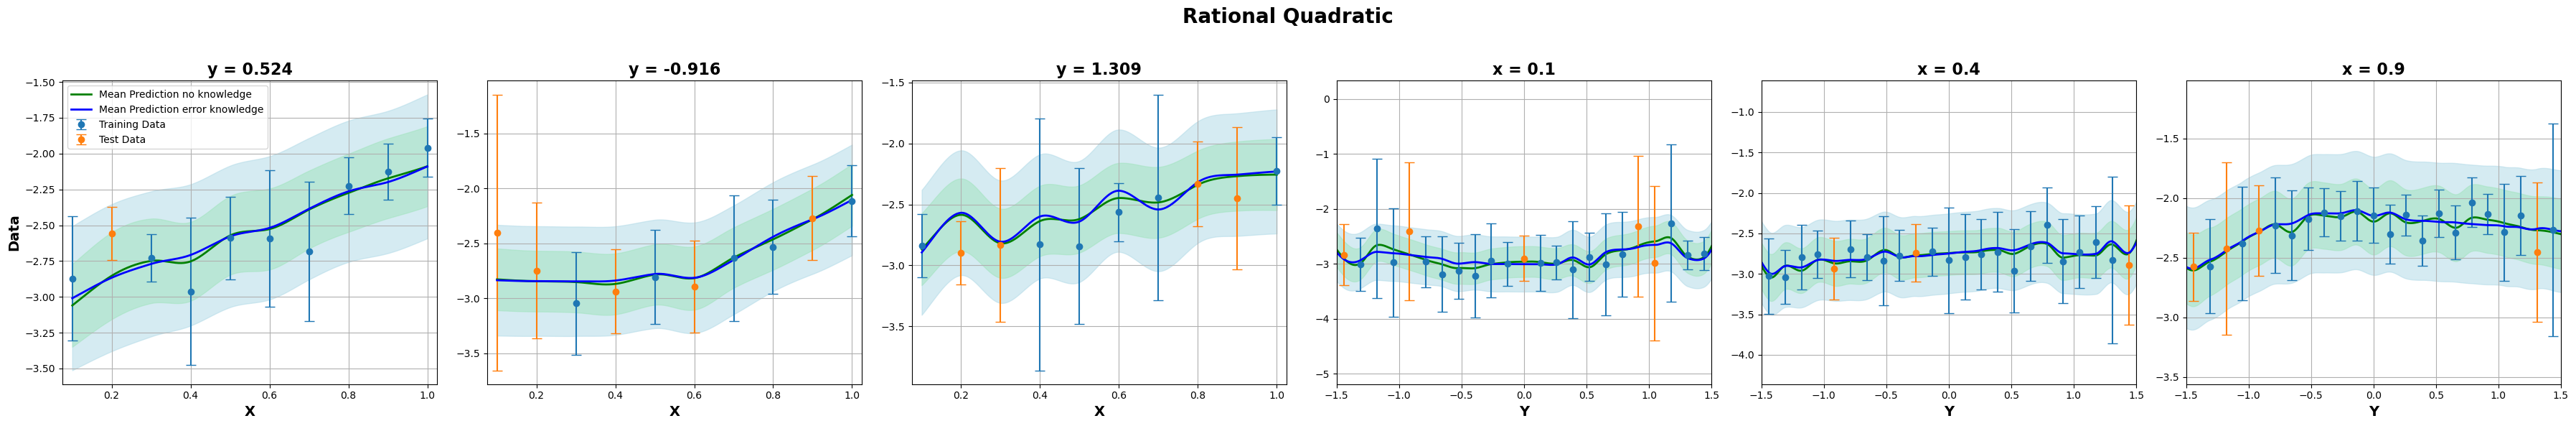

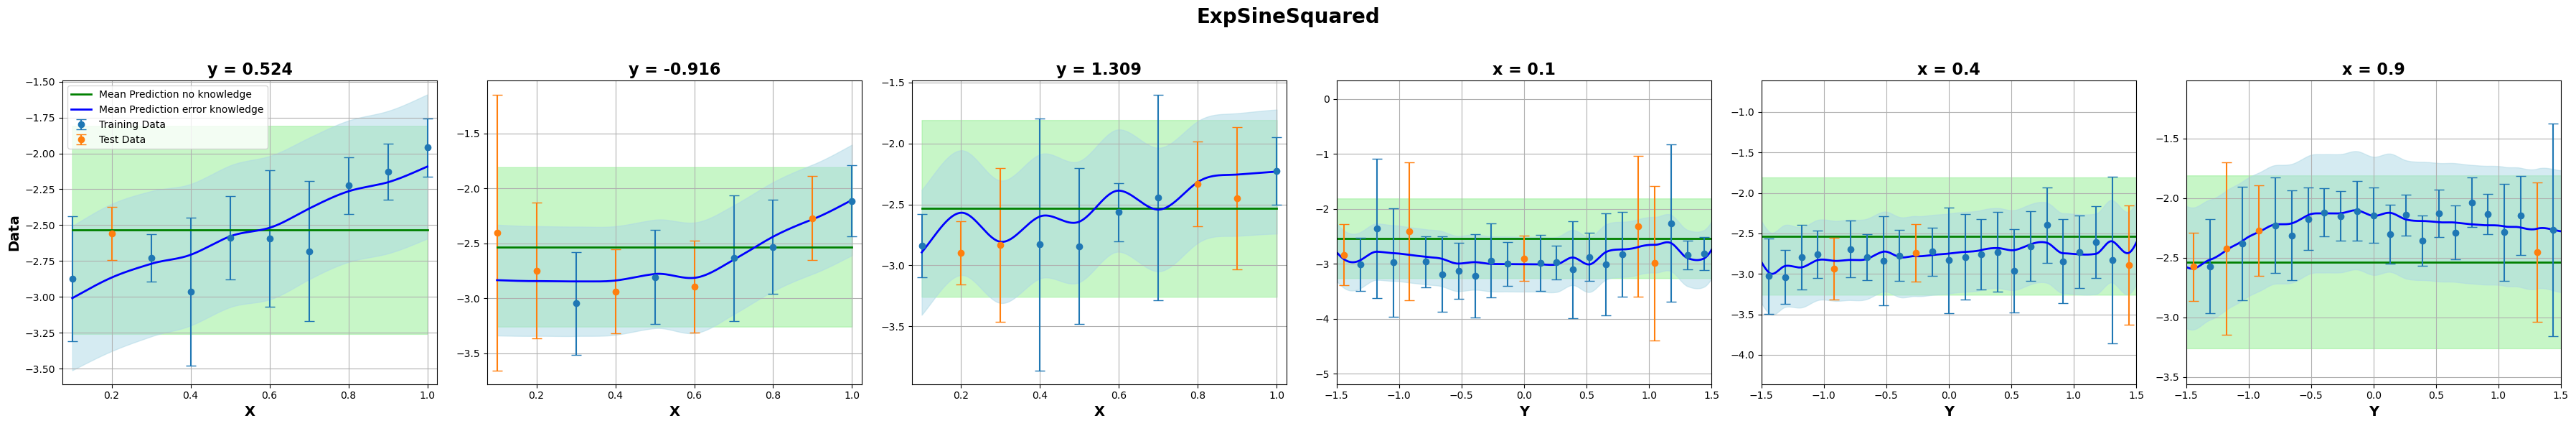

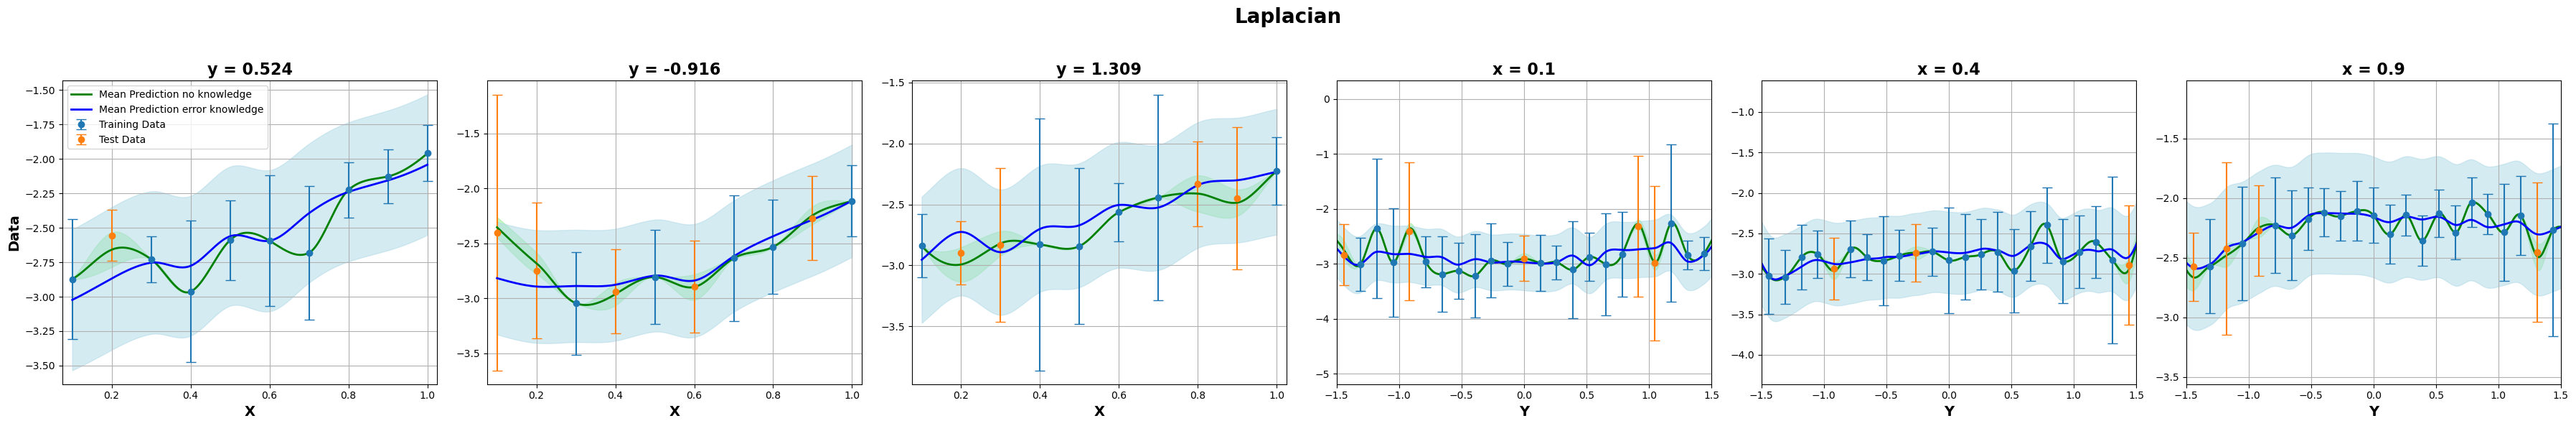

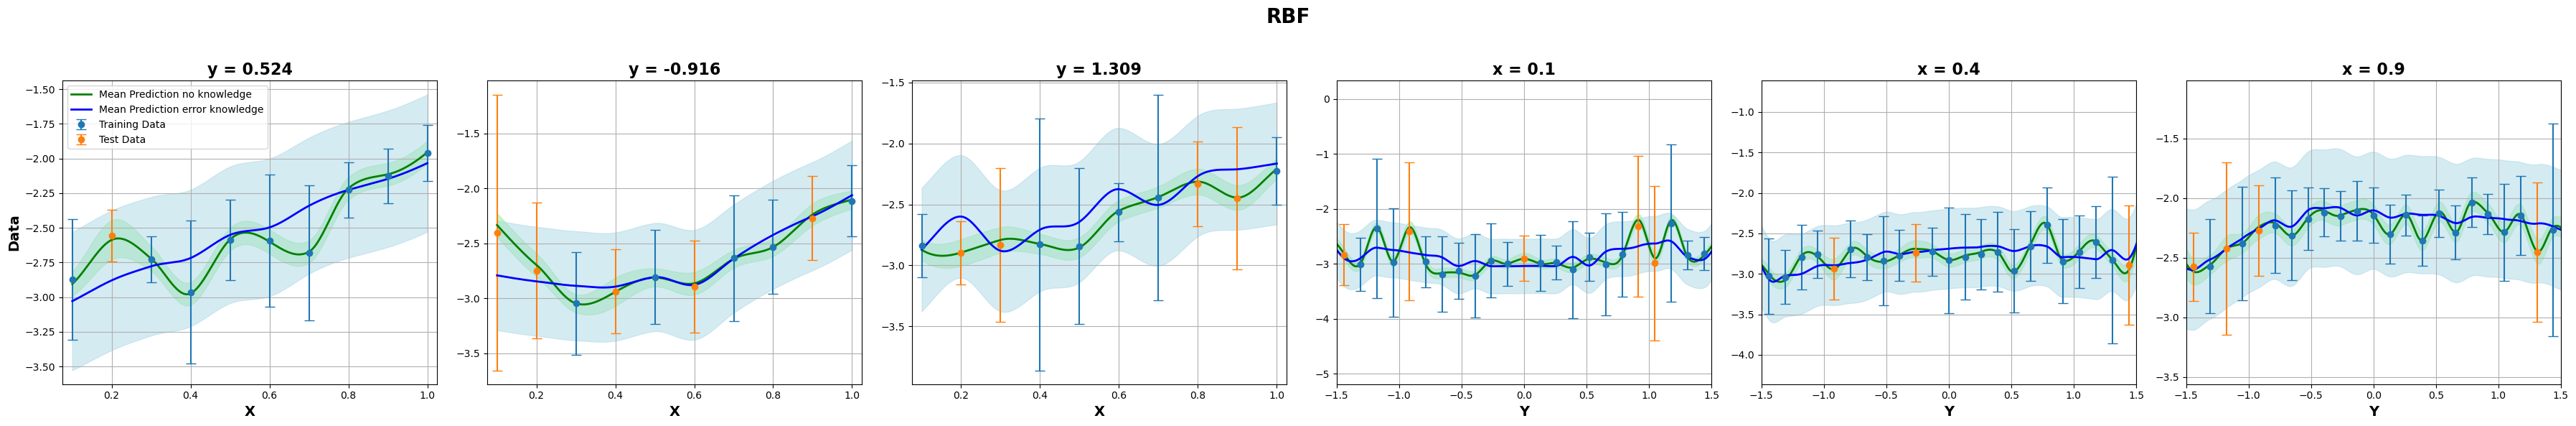

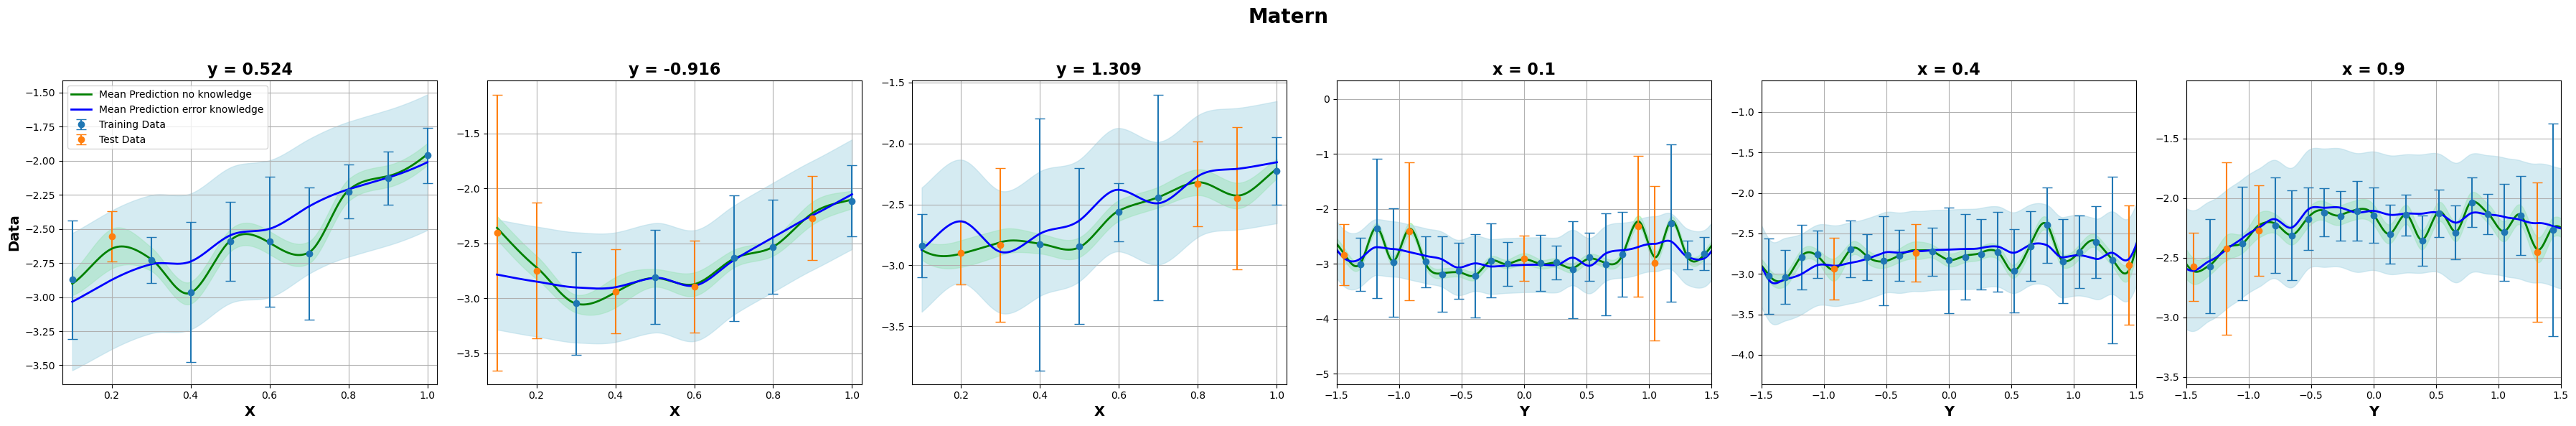

In [ ]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
xpoints = np.linspace(0, 1, 1000)
ypoints = [0.5235987755982988,-0.9162978572970231,1.3089969389957472]
ypoints2 = np.linspace(-1.5707963267948966,1.5707963267948966,1000)
xpoints2 = [ 0.1,0.4,0.9]
 
 
# Define the pairs of indices for the fits
jpairs = np.array([[0, 5], [1, 6], [2, 7], [3, 8], [4, 9]], dtype=int)

for i in range(5):
    j1, j2 = jpairs[i]
    fig, axes = plt.subplots(1, 6, figsize=(36, 6), sharey=False)
    # Set the title for the entire figure (each row)
    fig.suptitle(f"{kernel_names[i]}", fontsize=20, weight='bold')
    
    for k in range(6):
        ax = axes[k]
        if k < 3:
            zgridlinear_mean_j1 = griddata((xm1, ym1), fits[j1], (xpoints, ypoints[k]), method="cubic")
            zgridlinear_std_j1 = griddata((xm1, ym1), stds[j1], (xpoints, ypoints[k]), method="cubic")
            zgridlinear_mean_j2 = griddata((xm1, ym1), fits[j2], (xpoints, ypoints[k]), method="cubic")
            zgridlinear_std_j2 = griddata((xm1, ym1), stds[j2], (xpoints, ypoints[k]), method="cubic")
            indices1 = np.isclose(y1train, ypoints[k])
            indices2 = np.isclose(y1test, ypoints[k])
            ax.errorbar(x1train[indices1].ravel(),
                        D1_train[indices1].ravel(),
                        yerr=E1_train[indices1].ravel(),
                        fmt='o', capsize=5, label='Training Data')
            ax.errorbar(x1test[indices2].ravel(),
                        D1_test[indices2].ravel(),
                        yerr=E1_test[indices2].ravel(),
                        fmt='o', capsize=5, label='Test Data')
            ax.plot(xpoints, zgridlinear_mean_j1, label='Mean Prediction no knowledge', color='green', linewidth=2)
            ax.fill_between(xpoints, 
                            zgridlinear_mean_j1 - 2 * zgridlinear_std_j1, 
                            zgridlinear_mean_j1 + 2 * zgridlinear_std_j1,
                            color='lightgreen', alpha=0.5)
            ax.plot(xpoints, zgridlinear_mean_j2, label='Mean Prediction error knowledge', color='blue', linewidth=2)
            ax.fill_between(xpoints, 
                            zgridlinear_mean_j2 - 2 * zgridlinear_std_j2, 
                            zgridlinear_mean_j2 + 2 * zgridlinear_std_j2,
                            color='lightblue', alpha=0.5)
            ax.set_xlim((0.075, 1.025))
            ax.set_xlabel('X', fontsize=14, weight='bold')
            ax.set_title(f"y = {round(ypoints[k], 3)}", fontsize=16, weight='bold')
            ax.grid(True)
        else:
            xpoint = xpoints2[k - 3]
            zgridlinear_mean_j1 = griddata((xm1, ym1), fits[j1], (xpoint, ypoints2), method="cubic")
            zgridlinear_std_j1 = griddata((xm1, ym1), stds[j1], (xpoint, ypoints2), method="cubic")
            zgridlinear_mean_j2 = griddata((xm1, ym1), fits[j2], (xpoint, ypoints2), method="cubic")
            zgridlinear_std_j2 = griddata((xm1, ym1), stds[j2], (xpoint, ypoints2), method="cubic")
            indices1 = np.isclose(x1train, xpoint)
            indices2 = np.isclose(x1test, xpoint)
            ax.plot(ypoints2, zgridlinear_mean_j1, label='Mean Prediction no knowledge', color='green', linewidth=2)
            ax.errorbar(y1train[indices1].ravel(),
                        D1_train[indices1].ravel(),
                        yerr=E1_train[indices1].ravel(),
                        fmt='o', capsize=5, label='Training Data')
            ax.errorbar(y1test[indices2].ravel(),
                        D1_test[indices2].ravel(),
                        yerr=E1_test[indices2].ravel(),
                        fmt='o', capsize=5, label='Test Data')
            ax.fill_between(ypoints2, 
                            zgridlinear_mean_j1 - 2 * zgridlinear_std_j1, 
                            zgridlinear_mean_j1 + 2 * zgridlinear_std_j1,
                            color='lightgreen', alpha=0.5)
            ax.plot(ypoints2, zgridlinear_mean_j2, label='Mean Prediction error knowledge', color='blue', linewidth=2)
            ax.fill_between(ypoints2, 
                            zgridlinear_mean_j2 - 2 * zgridlinear_std_j2, 
                            zgridlinear_mean_j2 + 2 * zgridlinear_std_j2,
                            color='lightblue', alpha=0.5)
            ax.set_xlim((-1.5, 1.5))
            ax.set_xlabel('Y', fontsize=14, weight='bold')
            ax.set_title(f"x = {round(xpoints2[k - 3], 3)}", fontsize=16, weight='bold')
            ax.grid(True)
    
    # Optionally, add a common y-label for the leftmost subplot
    axes[0].set_ylabel('Data', fontsize=14, weight='bold')
    # Optionally, add the legend to the first subplot in this figure
    axes[0].legend(fontsize=10, loc='upper left', frameon=True)
    
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(f"{kernel_names[i]}", fontsize=20, weight='bold')
    plt.show()

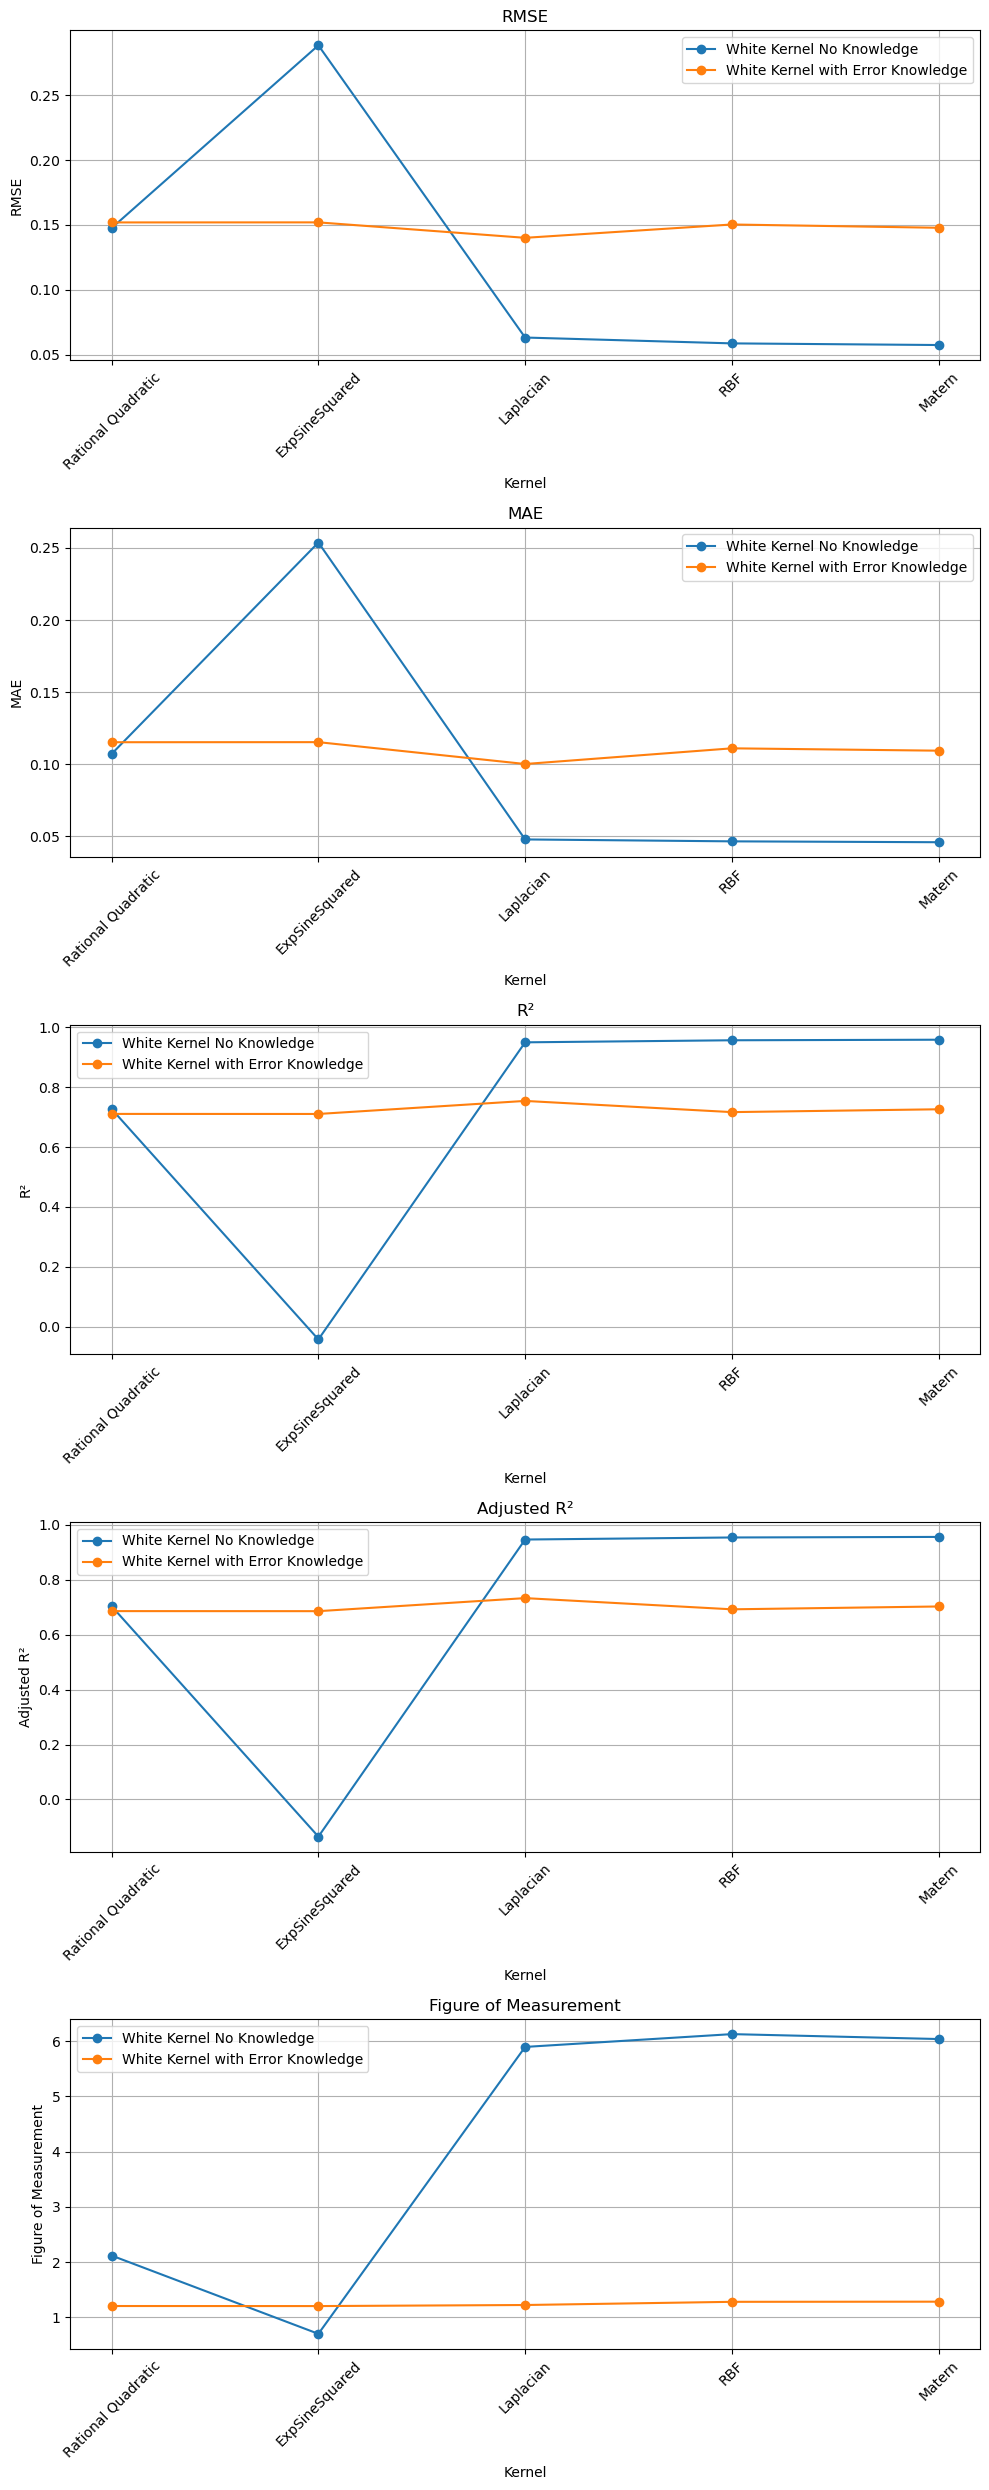

In [17]:
metrics = [rmse, mae, r2, adjustedr2, fom]
metric_names = ["RMSE", "MAE", "R²", "Adjusted R²", "Figure of Measurement"]
fitlabels = ["White Kernel No Knowledge", "White Kernel with Error Knowledge"]

# Distinct colors for the fits (2 colors)
colors = ['#1f77b4', '#ff7f0e']

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, m, name in zip(axes, metrics, metric_names):
    # x-axis: one value per kernel (5 values)
    x = np.arange(5)
    # Plot the "No Knowledge" results (first 5 elements) and the "With Error Knowledge" (next 5 elements)
    ax.plot(x, m[:5], '-o', label='White Kernel No Knowledge', color=colors[0])
    ax.plot(x, m[5:], '-o', label='White Kernel with Error Knowledge', color=colors[1])
    ax.set_xticks(x)
    ax.set_xticklabels(kernel_names, rotation=45)
    ax.set_xlabel("Kernel")
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend(loc='best')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [31]:
WhiteKernelNoKnowledgeMetrics = np.array(metrics)[:, :5]
WhiteKernelWithErrorKnowledgeMetrics = np.array(metrics)[:, 5:]
#### Each row is a metric, each column is a kernel

In [32]:
np.savetxt("WhiteKernelNoKnowledgeMetrics.csv", WhiteKernelNoKnowledgeMetrics, delimiter=",")
np.savetxt("WhiteKernelWithErrorKnowledgeMetrics.csv", WhiteKernelWithErrorKnowledgeMetrics, delimiter=",")